In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils.extmath import randomized_svd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Stochastic CUR

In [3]:
#%%writefile CUR.py
import numpy as np
import pandas as pd
from sklearn.utils.extmath import randomized_svd

class CUR():
    def __init__(self, k, eps, it=None, truncated=False):
        self.k = k
        self.eps = eps
        self.trunc = truncated 
        self.c = k * np.log(k) / eps**2 #expectation number of sampled columns
        self.C, self.U, self.R = None, None, None #matrices of decomposition
        self.pi_col, self.pi_row = None, None #leverage scores of corresponding columns/rows
        self.col_indices = None
        self.row_indices = None
    
    def column_select(self, A):
        n = A.shape[1]
        A = np.array(A.copy())
        if self.trunc:
            _, _, v_k = randomized_svd(A, self.k) #for very big matrices
        else:
            _, _, vh = np.linalg.svd(A, full_matrices=False)
            v_k = vh[0:self.k, :]
        
        pi = 1 / self.k * np.sum(v_k**2, axis=0)
        c_index = [np.random.choice(2, 
                        p=[1 - min(1, self.c * pi[i]), min(1, self.c * pi[i])]) for i in range(n)
                  ]
        c_index = np.nonzero(c_index)[0]
        
        C = A[:, c_index]
        return C, c_index, pi

    def run_CUR(self, A):
        A = np.array(A.copy())
        self.C, self.col_indices, self.pi_col = self.column_select(A)
        self.R, self.row_indices, self.pi_row = self.column_select(A.T)
        self.U = np.linalg.pinv(self.C) @ A @ np.linalg.pinv(self.R.T)
        return self.C, self.U, self.R.T

## Functional representation

In [152]:
###Functional representation
# def ColumnSelect(A, k, eps, truncated=False, return_indices=False):
#     n = A.shape[1]

#     if truncated:
#         u, s, v_k = randomized_svd(A, k) #for very big matrices
#     else:
#         u, s, vh = np.linalg.svd(A, full_matrices=False)
#         v_k = vh[0:k, :]

#     pi = 1 / k * np.sum(v_k**2, axis=0)
#     c = k * np.log(k) / eps**2
    
#     c_index = [np.random.choice(2, 
#                     p=[1 - min(1, c * pi[i]), min(1, c * pi[i])]) for i in range(n)
#               ]
#     c_index = np.nonzero(c_index)[0]
#     C = A[:, c_index]

#     if return_indices:
#         return C, c_index
#     else:
#         return C


# def CUR_stokh(A, k, eps, truncated=False):
#     C = ColumnSelect(A, k, eps, False)
#     R = ColumnSelect(A.T, k, eps, False).T
#     U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
#     return C, U, R

## First try

In [4]:
A = np.random.randn(10,8)

In [5]:
cur = CUR(k=2, eps=0.5,)

In [6]:
C,U,R = cur.run_CUR(A)
print(C.shape, U.shape, R.shape)

(10, 3) (3, 5) (5, 8)


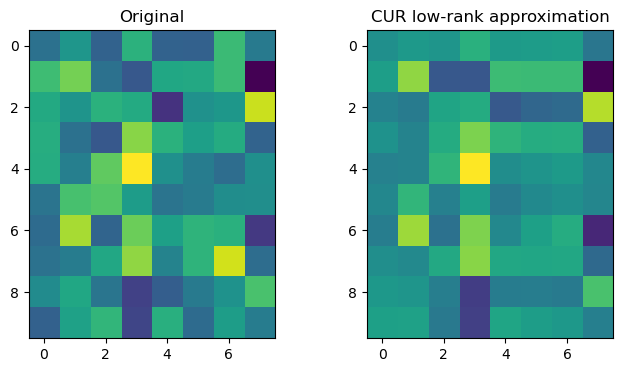

In [7]:
plt.figure(figsize=(8,4))

plt.subplot(121)
plt.imshow(A)
plt.title('Original')

plt.subplot(122)
plt.imshow(C@U@R) 
plt.title('CUR low-rank approximation')

plt.show()

# Kidney & Colon gene expression data

The data is taken from [OpenML project](https://www.openml.org/d/1137).

In [9]:
df = pd.read_csv('data/AP_Colon_Kidney.csv', index_col=0)

In [10]:
df.head()

,1007_s_at,121_at,1405_i_at,1438_at,1487_at,1494_f_at,1552256_a_at,1552257_a_at,1552274_at,1552275_s_at,...,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,Tissue
ID_REF,,,,,,,,,,,,,,,,,,,,,
203679,2883.2,2109.1,702.0,114.4,822.2,235.1,3346.1,815.1,233.3,218.4,...,2035.7,1908.1,30396.7,28371.7,85830.1,57084.9,3651.2,1736.1,2411.6,Kidney
179949,2607.4,1204.2,228.0,19.2,1497.1,167.6,23003.6,948.6,414.1,124.1,...,3811.6,3012.0,16748.8,13581.2,53322.5,37139.5,1648.1,502.9,890.6,Kidney
76558,2736.8,3912.2,1020.8,39.0,574.9,448.9,1337.9,605.6,176.8,411.9,...,17154.4,14835.5,64597.8,59311.2,203060.6,146422.6,3346.4,673.2,1499.3,Kidney
203712,1471.6,1318.2,4564.6,9.4,1426.5,105.2,2594.3,929.8,240.4,139.0,...,12382.2,11300.8,58551.7,49073.6,119460.8,95682.3,2553.5,961.2,1468.4,Kidney
102522,3564.7,2535.6,944.1,40.0,734.2,651.0,1490.5,712.3,632.7,185.0,...,13321.1,12966.9,54572.5,51049.1,178178.2,129533.2,3399.1,1209.8,1981.6,Kidney


In [11]:
X, y = df.drop('Tissue', 1), df['Tissue']
Xlog = np.log10(X + 1.0) #log expression data is more convenient to work

Below we compare a case of data dimensionality reduction with both CUR and SVD algorithms.

## SVD

In [12]:
X_log_centered = Xlog - Xlog.mean(0)
u,s,v = np.linalg.svd(X_log_centered)

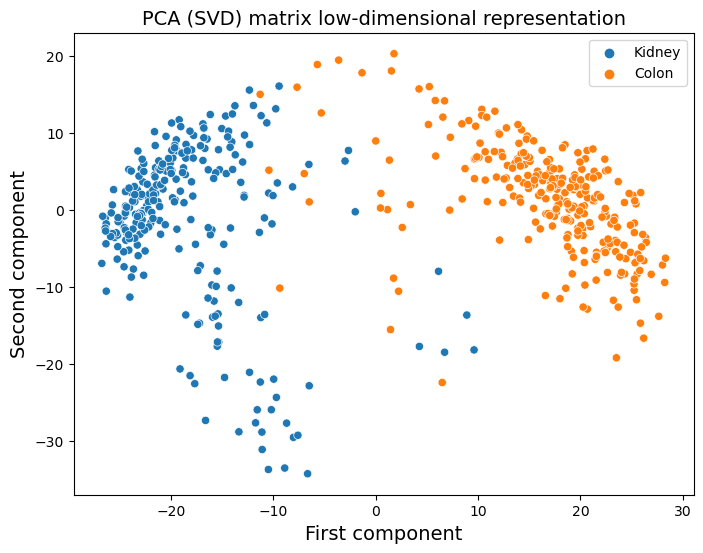

In [13]:
k=2
X_svd = (u@np.diag(s))[:,:k]

fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(X_svd[:,0], X_svd[:,1], hue=y, ax=ax)
plt.title('PCA (SVD) matrix low-dimensional representation', fontsize=14)
plt.xlabel('First component', fontsize=14)
plt.ylabel('Second component', fontsize=14)
ax.legend()


plt.show()

## CUR

CUR return a random number of vectors for given $\epsilon$ and $k$ parameters. Therefore it may require several runs to return a definite number of column vectors of matrix $C$ (or $R$).

In [16]:
cur = CUR(2, 0.5, truncated=False)
C,U,R = cur.run_CUR(Xlog)
C.shape

(546, 4)

In [17]:
ids = np.argsort(cur.pi_col)[::-1][:5]
ids #top 5 genes by leverage score

array([4111, 9992, 3238, 1481, 2728], dtype=int64)

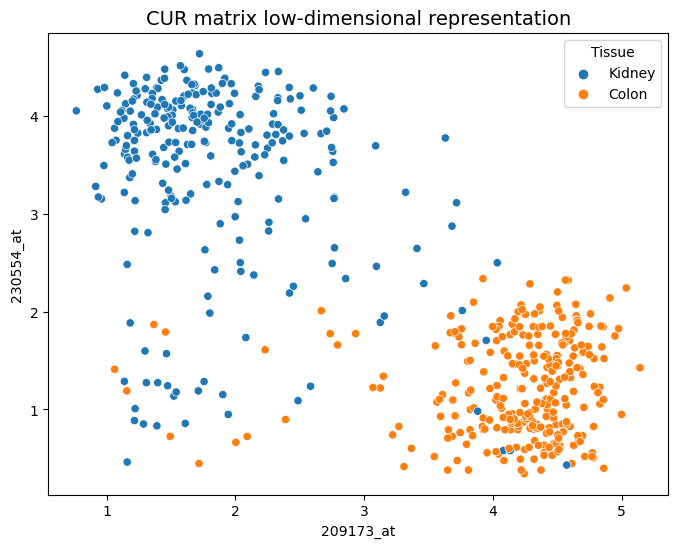

In [18]:
#plot 2 of them
fig, ax = plt.subplots(figsize=(8,6))
x1 = Xlog.iloc[:, ids[0]]
x2 = Xlog.iloc[:, ids[1]]
sns.scatterplot(x1, x2, hue=y, ax=ax)
plt.title('CUR matrix low-dimensional representation', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()

In [19]:
#construct projection of data matrix on the space of selected columns
X_proj = C@np.linalg.pinv(C)@Xlog

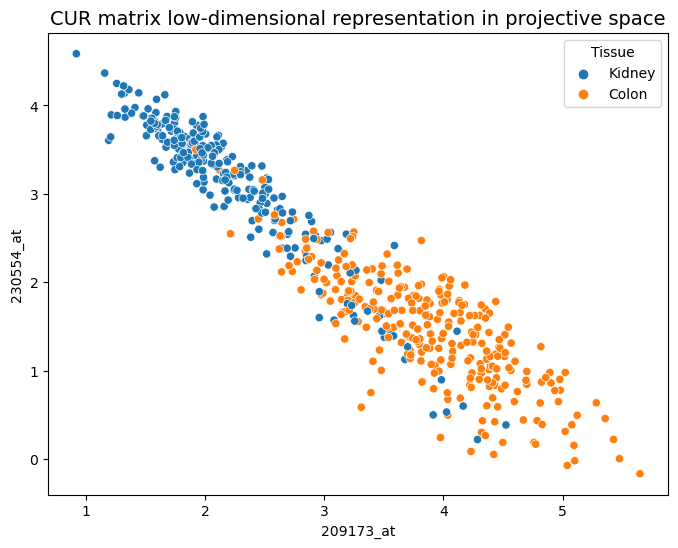

In [20]:
#plot 2 of them
fig, ax = plt.subplots(figsize=(8,6))
x1 = X_proj.iloc[:, ids[0]]
x2 = X_proj.iloc[:, ids[1]]
sns.scatterplot(np.array(x1), np.array(x2), hue=y, ax=ax)
plt.title('CUR matrix low-dimensional representation in projective space', fontsize=14)
plt.xlabel(x1.name)
plt.ylabel(x2.name)

plt.show()